# Estudio del tráfico en el área urbana de Madrid. Parte II

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster


## Datos e información

Se hace uso de la programación funcional para reutilizar el máximo código posible.

In [2]:
# Literales a usar en todo el código
stationCol = 'station_id'
dayCol = 'day_id'
timeCol = 'time_id'
magnitudCol = 'magnitud'
valueCol = 'value'
validationCol = 'validation'
monthCol = 'month_id'
day = 'day'

Importar todos los datos tratados según el notebook _Estudio_trafico_adaptado_template.ipynb_.
Concatenar los DF para poder realizar análisis.

_Nota:_ Se podría utilizar ```vaex``` como alernativa al código descrito para agilizar los tiempos de ejecución ya que es una librería Python similar a Pandas para visualizar y explorar grandes datasets. 

In [3]:
#Importar los años de estudio
tot_16 = pd.read_csv("trf2016_bool.csv", sep = ";", header = "infer", encoding='iso-8859-1')
tot_17 = pd.read_csv("trf17.csv", sep = ";", header = "infer", encoding='iso-8859-1')
tot_18 = pd.read_csv("trf2018.csv", sep = ";", header = "infer", encoding='iso-8859-1')
tot_19 = pd.read_csv("trf2019.csv", sep = ";", header = "infer", encoding='iso-8859-1')

In [4]:
#Concatenar todos los DF para obtener uno único 
trfList = [tot_16,
            tot_17,
            tot_18,
            tot_19]
anual_trf = pd.concat(trfList, axis=0)
anual_trf.head()

station_id      day_id  time_id  magnitud_id   value validation  day  \
0        3395  2016-01-01        0           52   480.0          t    1   
1        3395  2016-01-01        1           52  2092.0          t    1   
2        3395  2016-01-01        2           52  1998.0          t    1   
3        3395  2016-01-01        3           52  1000.0          t    1   
4        3395  2016-01-01        4           52   687.0          t    1   

   month_id  
0         1  
1         1  
2         1  
3         1  
4         1

Importar las estaciones previamente filtradas en función del área de estudio y filtrar el DF.

In [5]:
#Importar las estaciones de medida de tráfico de estudio
estaciones_trf = pd.read_csv("Station_list.csv", sep = ",", header = "infer", encoding='iso-8859-1')
estaciones_trf1 = estaciones_trf[(estaciones_trf['type'] == 'URB')]
estaciones_trf1.head()

station_id  district                                            address  \
0            0         7  (MICRO)San Fco. de Sales S-N(Giro a Guzman el ...   
48        3395         7  SANTANDER S-N (MELQUIADES ALVAREZ-SAN FRANCISC...   
49        3396         7  CEA BERMUDEZ E-O (SAN GABRIEL - SAN FRANCISCO ...   
50        3397         7  CEA BERMUDEZ O-E (ANDRES MELLADO-GUZMAN EL BUENO)   
51        3398         5   CORAZSN DE MARIA S-N(SANTA HORTENSIA-SANTA RITA)   

   type   latitude  longitude        date  
0   URB  40.442788  -3.712340  2020-01-20  
48  URB  40.442836  -3.709570  2020-01-20  
49  URB  40.439236  -3.716360  2020-01-20  
50  URB  40.439020  -3.713966  2020-01-20  
51  URB  40.444360  -3.667132  2020-01-20

In [6]:
#Seleccionar columnas de interés
anual_trf = anual_trf[[stationCol, dayCol,  day, monthCol, timeCol, valueCol]]

In [7]:
#Filtrar estaciones de estudio
anual_filtrado = anual_trf[anual_trf[stationCol].isin(estaciones_trf[stationCol])]

In [8]:
#Pasar de objeto a formato fecha
anual_filtrado[dayCol] = pd.to_datetime(anual_filtrado[dayCol])

##Sacar columna año
anual_filtrado['year'] = anual_filtrado[dayCol].dt.year

anual_filtrado.head()

station_id     day_id  day  month_id  time_id   value  year
0        3395 2016-01-01    1         1        0   480.0  2016
1        3395 2016-01-01    1         1        1  2092.0  2016
2        3395 2016-01-01    1         1        2  1998.0  2016
3        3395 2016-01-01    1         1        3  1000.0  2016
4        3395 2016-01-01    1         1        4   687.0  2016

### Intensidad Media Diaria (IMD)
Como medida de estudio del tráfico. Se refiere a la cantidad media de vehículos que circulan en el área de estudio.

#### IMD Anual

In [9]:
##Agrupar todos los valores registrados por años
trf_anual = anual_filtrado.groupby(['year'])[valueCol].sum().reset_index()

#Calcular IMD anual
trf_anual["IMDm_Vh_Dia"] = [value/ 365/1000 for value in trf_anual.value]
trf_anual.IMDm_Vh_Dia = trf_anual.IMDm_Vh_Dia.mask(
     trf_anual.year == 2016, trf_anual.value/ 366/1000)

trf_anual = trf_anual.round(0)

trf_anual.head()

year         value  IMDm_Vh_Dia
0  2016  3.646498e+10      99631.0
1  2017  3.819842e+10     104653.0
2  2018  3.943211e+10     108033.0
3  2019  3.810431e+10     104395.0

#### IMD Mensual 

In [10]:
##Agrupar todos los valores registrados por mes y día
trf_mes = anual_filtrado.groupby(['year', monthCol, day])[valueCol].sum().reset_index()
trf_mes.head()

year  month_id  day        value
0  2016         1    1   65972375.0
1  2016         1    2   74652838.0
2  2016         1    3   72784470.0
3  2016         1    4  108812413.0
4  2016         1    5  105279573.0

In [11]:
#Calcular IMD mensual
trf_mes1 = trf_mes.groupby(['year', monthCol])[valueCol].mean().reset_index()
trf_mes1["IMDm_Vh_Dia"] = [value/1000 for value in trf_mes1.value]
trf_mes1["IMDm_Vh_Dia"] = trf_mes1["IMDm_Vh_Dia"].astype(int)
trf_mes1 = trf_mes1[['year', monthCol, 'IMDm_Vh_Dia']]

trf_mes2 = trf_mes1.pivot(index=monthCol, columns='year').reset_index()
trf_mes2.head(12)

month_id IMDm_Vh_Dia                        
year                 2016    2017    2018    2019
0           1      104411   97769  113506  102261
1           2      110595  102849  115694  109974
2           3      100242  113404  108605  109044
3           4      107766  104167  114899  100446
4           5      109621  111381  113717  106267
5           6      109629  115997  117390  108579
6           7       98439  100211  103704  101418
7           8       75088   75058   78583   74052
8           9      108712  109314  106632  108355
9          10      106785  113382  110891  115278
10         11      107000  114131  108432  113369
11         12       99521  109386  105571  104660

## Visualización para el análisis

### Mapa con los puntos incluidos en el estudio

In [12]:
#Crear mapa
map_madrid = folium.Map(location=[40.42, -3.7], zoom_start=12,
                        tiles='Stamen Toner')

#Añadir marcadores a las estaciones de medida
estaciones_trf1.apply(
    lambda row: folium.CircleMarker([row.latitude, row.longitude], 
                                    radius=1, color='green', 
                                    tooltip=row.station_id)
    .add_to(map_madrid),axis=1)

#Añadir clusters en función del distrito para ver de manera más visual cómo están distribuidos y cuántos son
mc = MarkerCluster()
for row in estaciones_trf1.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude, row.longitude],
                 tooltip=row.district))
 
map_madrid.add_child(mc)

map_madrid

### Gráficos de los datos

#### Evolución del tráfico por meses

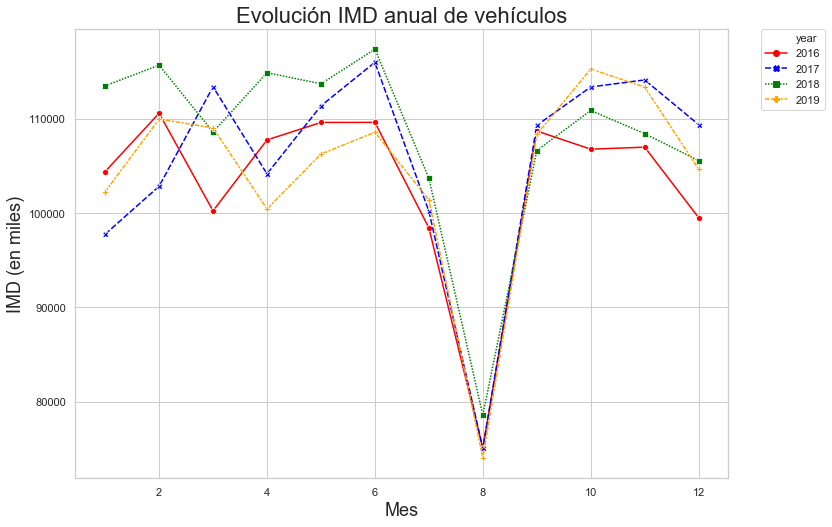

In [13]:
# Gráfica por meses de los años de estudio
palette = ['red', 'blue', 'green','orange']

sns.set(style="whitegrid")
dimentions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimentions)
graph = sns.lineplot(x = monthCol, y="IMDm_Vh_Dia",
                     style='year',
                     hue='year',
                     markers=True, 
                     dashes=True,
                     palette=palette,
                     data=trf_mes1, ax=ax)

graph.axes.set_title("Evolución IMD anual de vehículos",fontsize=22)
graph.set_xlabel("Mes",fontsize=18)
graph.set_ylabel("IMD (en miles)",fontsize=18)
graph.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Se observa un claro descenso en los meses de verano, siendo agosto el mes claramente diferenciado.
- La intensidad de vehículos ha descendido el último año, si bien no ha llegado a niveles de 2016 todavía.

#### Evolución del tráfico por días

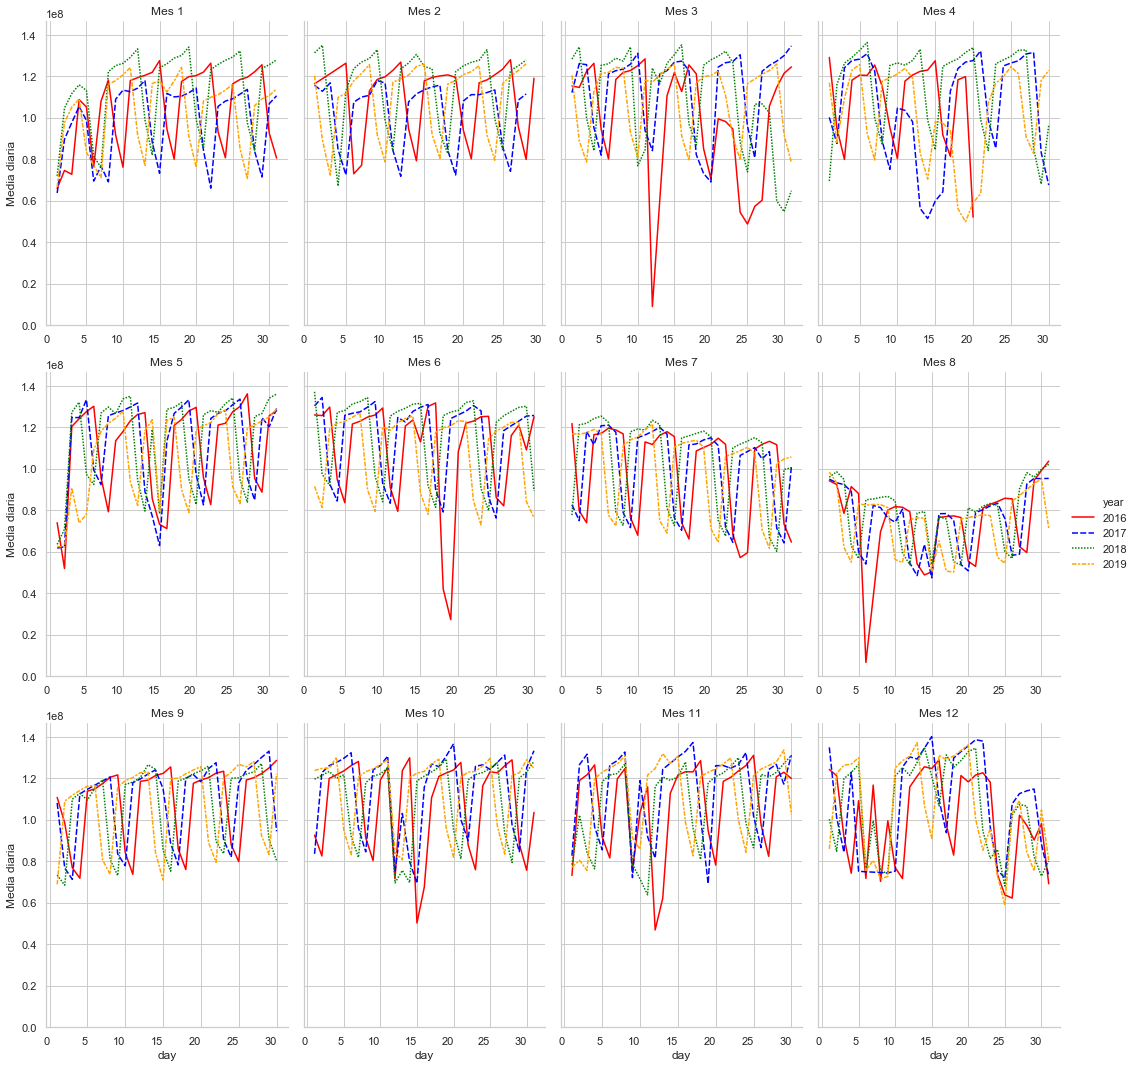

In [14]:
# Gráfica por día de los años de estudio
 
graph = sns.relplot(x=day, y=valueCol,
            hue="year", col=monthCol,
            style="year",
            size_order=["T1", "T2"], palette=palette,
            height=5, aspect=.75, facet_kws=dict(sharex=False),
            kind="line", legend="full",
            col_wrap=4,
            markers=False,
            data=trf_mes).set_titles("Mes {col_name}")

graph.set_xticklabels(rotation=0, horizontalalignment='right')
graph.set(ylabel='Media diaria')

- Nótese que el pico de descenso que se observa en marzo y agoso de 2016 es por ausencia de datos.
- Se extrae el patrón 'IMD alta días laborables-IMD baja fines de semana y festivos'

### Conclusión

Se presenta una manera visual para estudiar la evolución del tráfico fácilmente tras un trabajo de transformación y limpieza de los datos. De entre todas las librerías de Python, se ha hecho uso de ```seaborn```.